# Exemplo 1: Países

In [1]:
# Importando os pacotes - gerais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Importando os pacotes - clusterização
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import scipy.stats as stats
from sklearn.cluster import KMeans


# Importando os pacotes - PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import pingouin as pg

## 1.1. Base de dados

In [2]:
# Importando os dados

df = pd.read_csv("datasets/paises_pca_cluster.csv")

In [3]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
unique,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,NaN,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,NaN,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,NaN,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,NaN,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,NaN,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000


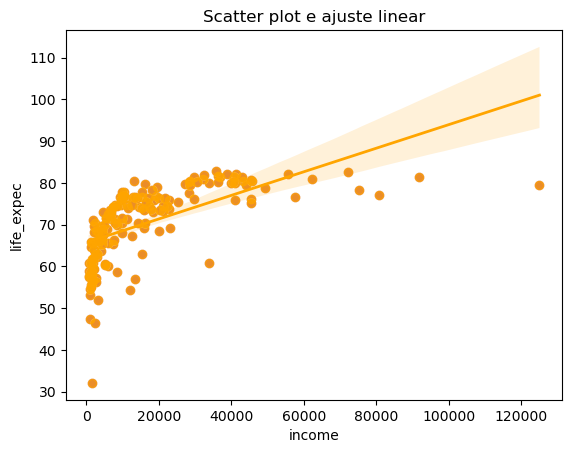

In [6]:
# Scatter e ajuste linear entre as variáveis 'income' e 'life_expec'

# Scatter plot e ajuste linear
sns.scatterplot(data=df, x='income', y='life_expec', color='darkorchid', s=50)
sns.regplot(data=df, x='income', y='life_expec', color='orange', line_kws={'linewidth': 2})

# Configurações dos eixos e do título
plt.xlabel('income')
plt.ylabel('life_expec')
plt.title('Scatter plot e ajuste linear')

# Exibição do gráfico
plt.show()

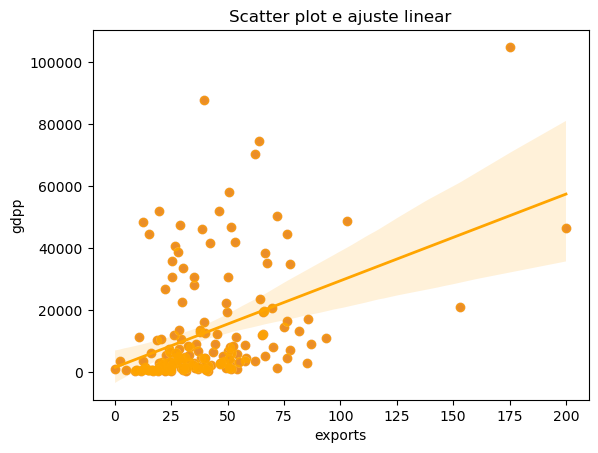

In [7]:
# Scatter e ajuste linear entre as variáveis 'exports' e 'gdpp'

# Scatter plot e ajuste linear
sns.scatterplot(data=df, x='exports', y='gdpp', color='darkorchid', s=50)
sns.regplot(data=df, x='exports', y='gdpp', color='orange', line_kws={'linewidth': 2})

# Configurações dos eixos e do título
plt.xlabel('exports')
plt.ylabel('gdpp')
plt.title('Scatter plot e ajuste linear')

# Exibição do gráfico
plt.show()

In [8]:
#%% Separando somente as variáveis quantitativas do banco de dados

df_pca = df.iloc[:, 1:]

df_pca.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## 1.2. PCA

### 1º Passo: Correlação de Pearson

In [9]:
#%% Matriz de correlaçãoes entre as variáveis

matriz_corr = pg.rcorr(df_pca, method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
matriz_corr


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,-,***,***,,***,***,***,***,***
exports,-0.3181,-,,***,***,,***,***,***
health,-0.2004,-0.1144,-,,*,***,***,**,***
imports,-0.1272,0.7374,0.0957,-,,***,,**,
income,-0.5243,0.5168,0.1296,0.1224,-,*,***,***,***
inflation,0.2883,-0.1073,-0.2554,-0.247,-0.1478,-,***,***,***
life_expec,-0.8867,0.3163,0.2107,0.0544,0.612,-0.2397,-,***,***
total_fer,0.8485,-0.32,-0.1967,-0.159,-0.5018,0.3169,-0.7609,-,***
gdpp,-0.483,0.4187,0.346,0.1155,0.8956,-0.2216,0.6001,-0.4549,-


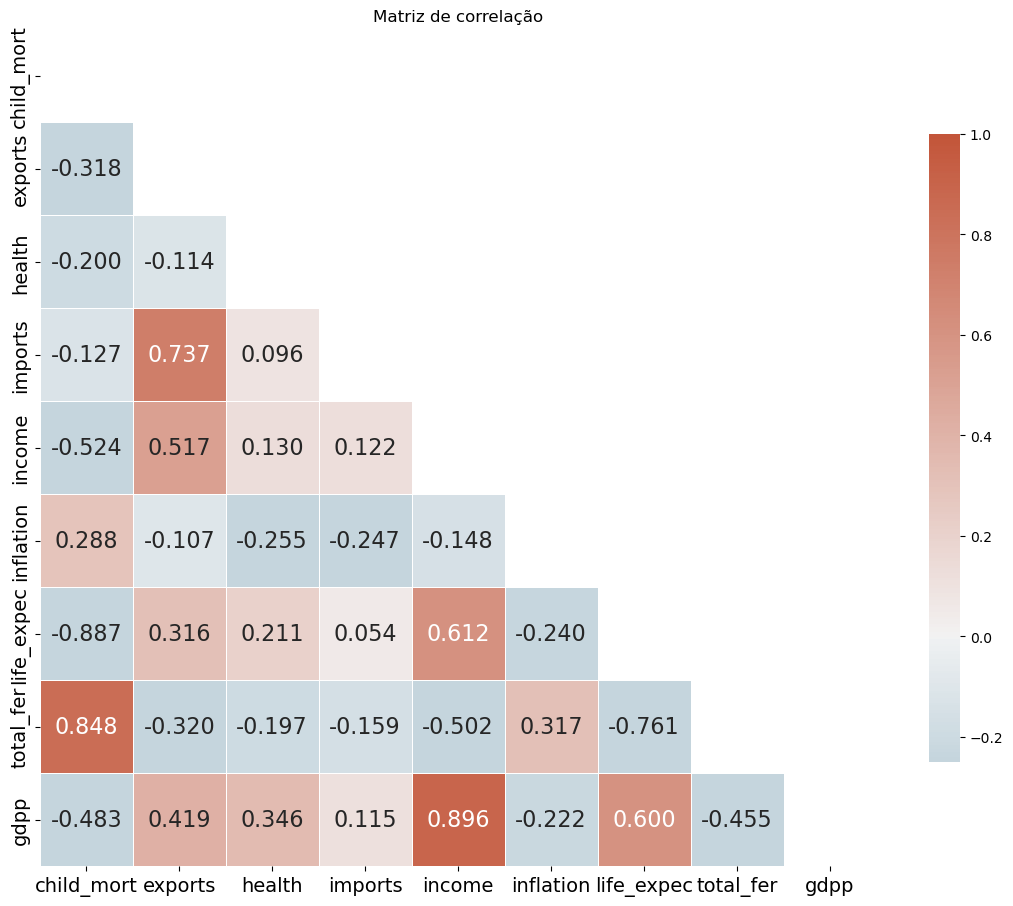

In [10]:
#%% Outra maneira de plotar as mesmas informações

corr = df_pca.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, n=256, as_cmap=True)

sns.heatmap(df_pca.corr(), 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin = -.25,
            center=0,
            square=True, 
            linewidths=.5,
            annot = True,
            fmt='.3f', 
            annot_kws={'size': 16},
            cbar_kws={"shrink": .75})

plt.title('Matriz de correlação')
plt.tight_layout()
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_ylim(len(corr))

plt.show()

### 2º Passo: Teste de Esferecidade de Bartlett

In [11]:
#%% Teste de Bartlett

bartlett, p_value = calculate_bartlett_sphericity(df_pca)

print(f'Bartlett statistic: {bartlett}')

print(f'p-value : {p_value}')

Bartlett statistic: 1169.73724416545
p-value : 3.1368618582678066e-222


### 3º Passo: PCA

In [12]:
#%% Definindo a PCA (procedimento preliminar)

fa = FactorAnalyzer()
fa.fit(df_pca)

FactorAnalyzer(rotation_kwargs={})

In [13]:
#%% Obtendo os Eigenvalues (autovalores)

ev, v = fa.get_eigenvalues()

print(ev)

# Temos 4 autovalores para este exemplo, pois são 4 variáveis

# Critério de Kaiser

# Verificar autovalores com valores maiores que 1
# Existem três componentes acima de 1


[4.13565658 1.54634631 1.1703833  0.99478456 0.66061903 0.22358112
 0.11343874 0.08831536 0.06687501]


In [14]:
#%% Parametrizando a PCA para dois fatores (autovalores > 1)

fa.set_params(n_factors = 3, method = 'principal', rotation = None)
fa.fit(df_pca)

FactorAnalyzer(method='principal', rotation=None, rotation_kwargs={})

In [15]:
#%% Eigenvalues, variâncias e variâncias acumulada

eigen_fatores = fa.get_factor_variance()
eigen_fatores

tabela_eigen = pd.DataFrame(eigen_fatores)
tabela_eigen.columns = [f"Fator_{i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

tabela_eigen

,Autovalor,Variância,Variância Acumulada
Fator_1,4.135657,0.459517,0.459517
Fator_2,1.546346,0.171816,0.631334
Fator_3,1.170383,0.130043,0.761376


In [16]:
#%% Determinando as cargas fatoriais

cargas_fatores = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatores)
tabela_cargas.columns = [f"Fator_{i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = df_pca.columns
tabela_cargas

tabela_cargas

,Fator_1,Fator_2,Fator_3
child_mort,-0.853148,0.239855,-0.031961
exports,0.577342,0.762482,0.156608
health,0.306749,-0.302284,-0.645462
imports,0.328396,0.835424,-0.324474
income,0.810282,0.028023,0.326227
inflation,-0.392843,-0.010451,0.695105
life_expec,0.866000,-0.276941,0.123242
total_fer,-0.821036,0.193036,0.021149
gdpp,0.798495,-0.057230,0.133042


In [17]:
#%% Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = df_pca.columns


tabela_comunalidades

,Comunalidades
child_mort,0.786413
exports,0.939229
health,0.602092
imports,0.911059
income,0.763767
inflation,0.637605
life_expec,0.841841
total_fer,0.711810
gdpp,0.658570


In [18]:
#%% Resultados dos fatores para as observações do dataset (predict)

predict_fatores= pd.DataFrame(fa.transform(df_pca))
predict_fatores.columns =  [f"Fator_{i+1}" for i, v in enumerate(predict_fatores.columns)]

predict_fatores

,Fator_1,Fator_2,Fator_3
0,-1.432425,0.076895,-0.663792
1,0.211401,-0.472976,-0.308257
2,-0.140254,-0.366037,1.129097
3,-1.441964,1.363511,1.409673
4,0.508242,0.109897,-0.208645
...,...,...,...
162,-0.403530,0.514322,-0.360425
163,-0.270961,-0.992251,2.866730
164,0.245140,1.118392,-0.220481
165,-0.928119,-0.088019,1.025798


In [19]:
# Adicionando ao dataset 

df = pd.concat([df.reset_index(drop=True), predict_fatores], axis=1)

df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Fator_1,Fator_2,Fator_3
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,-1.432425,0.076895,-0.663792
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0.211401,-0.472976,-0.308257
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,-0.140254,-0.366037,1.129097
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,-1.441964,1.363511,1.409673
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0.508242,0.109897,-0.208645
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,-0.403530,0.514322,-0.360425
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,-0.270961,-0.992251,2.866730
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,0.245140,1.118392,-0.220481
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,-0.928119,-0.088019,1.025798


In [20]:
# Identificando os scores fatoriais

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator_{i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = df_pca.columns

tabela_scores


,Fator_1,Fator_2,Fator_3
child_mort,-0.206291,0.155111,-0.027309
exports,0.139601,0.493086,0.133809
health,0.074172,-0.195483,-0.551496
imports,0.079406,0.540256,-0.277237
income,0.195926,0.018122,0.278735
inflation,-0.094989,-0.006759,0.593912
life_expec,0.209399,-0.179094,0.105300
total_fer,-0.198526,0.124833,0.018070
gdpp,0.193076,-0.037010,0.113674


In [21]:
#%% Correlação entre os fatores

# A seguir, verifica-se que a correlação entre os fatores é zero (ortogonais)

corr_fator = pg.rcorr(df[['Fator_1','Fator_2', 'Fator_3']], method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
corr_fator


,Fator_1,Fator_2,Fator_3
Fator_1,-,,
Fator_2,-0.0,-,
Fator_3,-0.0,-0.0,-


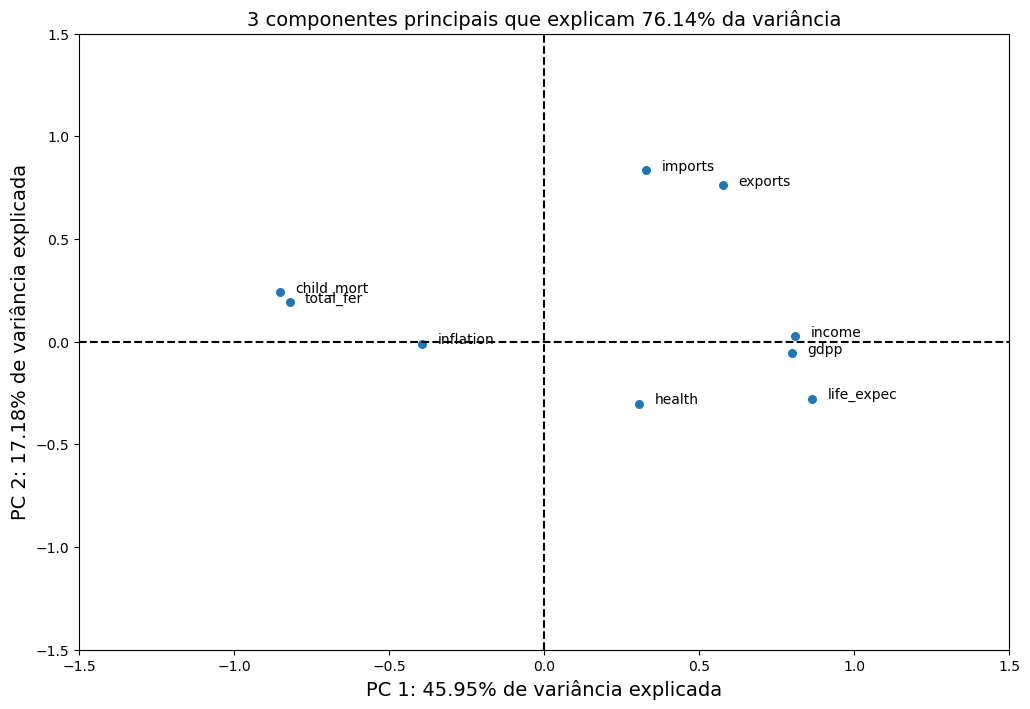

In [22]:
# Gráfico das cargas fatoriais e suas variâncias nos componentes principais
# Loading plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

tabela_cargas_chart = tabela_cargas.reset_index()

plt.scatter(tabela_cargas_chart['Fator_1'], tabela_cargas_chart['Fator_2'], s=30)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = tabela_cargas_chart['Fator_1'],
            y = tabela_cargas_chart['Fator_2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='black', ls='--')
plt.axvline(x=0, color='black', ls='--')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.title(f"{tabela_eigen.shape[0]} componentes principais que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=14)
plt.xlabel(f"PC 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=14)
plt.ylabel(f"PC 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=14)
plt.show()

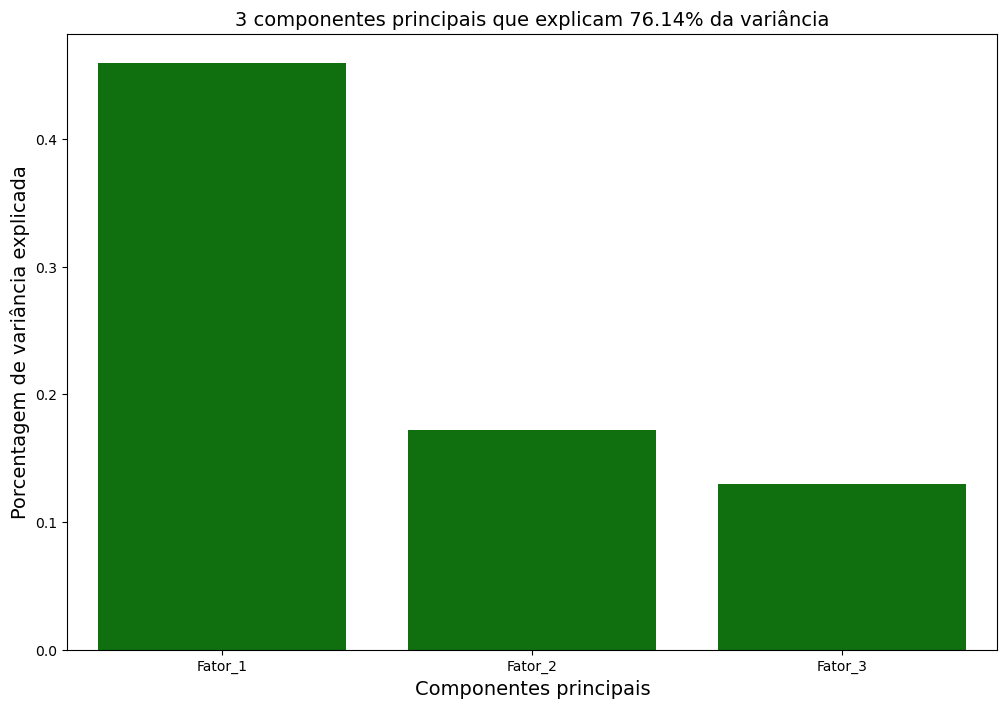

In [23]:
#%% Gráfico da variância acumulada dos componentes principais

plt.figure(figsize=(12,8))

plt.title(f"{tabela_eigen.shape[0]} componentes principais que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=14)
sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, color='green')
plt.xlabel("Componentes principais", fontsize=14)
plt.ylabel("Porcentagem de variância explicada", fontsize=14)
plt.show()

## 1.3. Clusterização hierárquica aglomerativa

In [24]:
#%% Separando somente as variáveis pertinentes a clusterização

df_cluster = df[['country', 'Fator_1', 'Fator_2', 'Fator_3']]
df_cluster.head(5)

,country,Fator_1,Fator_2,Fator_3
0,Afghanistan,-1.432425,0.076895,-0.663792
1,Albania,0.211401,-0.472976,-0.308257
2,Algeria,-0.140254,-0.366037,1.129097
3,Angola,-1.441964,1.363511,1.409673
4,Antigua and Barbuda,0.508242,0.109897,-0.208645


In [25]:
# Estatísticas descritivas dos fatores
summary = df_cluster.describe(include = 'all')
print(summary)

## ATENÇÃO: os clusters serão formados a partir dos 3 fatores
## Não aplicaremos o Z-Score, pois os fatores já são padronizados

            country       Fator_1       Fator_2       Fator_3
count           167  1.670000e+02  1.670000e+02  1.670000e+02
unique          167           NaN           NaN           NaN
top     Afghanistan           NaN           NaN           NaN
freq              1           NaN           NaN           NaN
mean            NaN  1.196648e-16  1.479189e-16 -3.207680e-16
std             NaN  1.003008e+00  1.003008e+00  1.003008e+00
min             NaN -2.415416e+00 -2.410384e+00 -2.508761e+00
25%             NaN -6.797054e-01 -6.047727e-01 -4.823970e-01
50%             NaN  1.101835e-02 -7.599279e-02 -2.270255e-01
75%             NaN  6.020403e-01  4.450865e-01  3.720922e-01
max             NaN  3.401676e+00  5.373521e+00  5.647918e+00


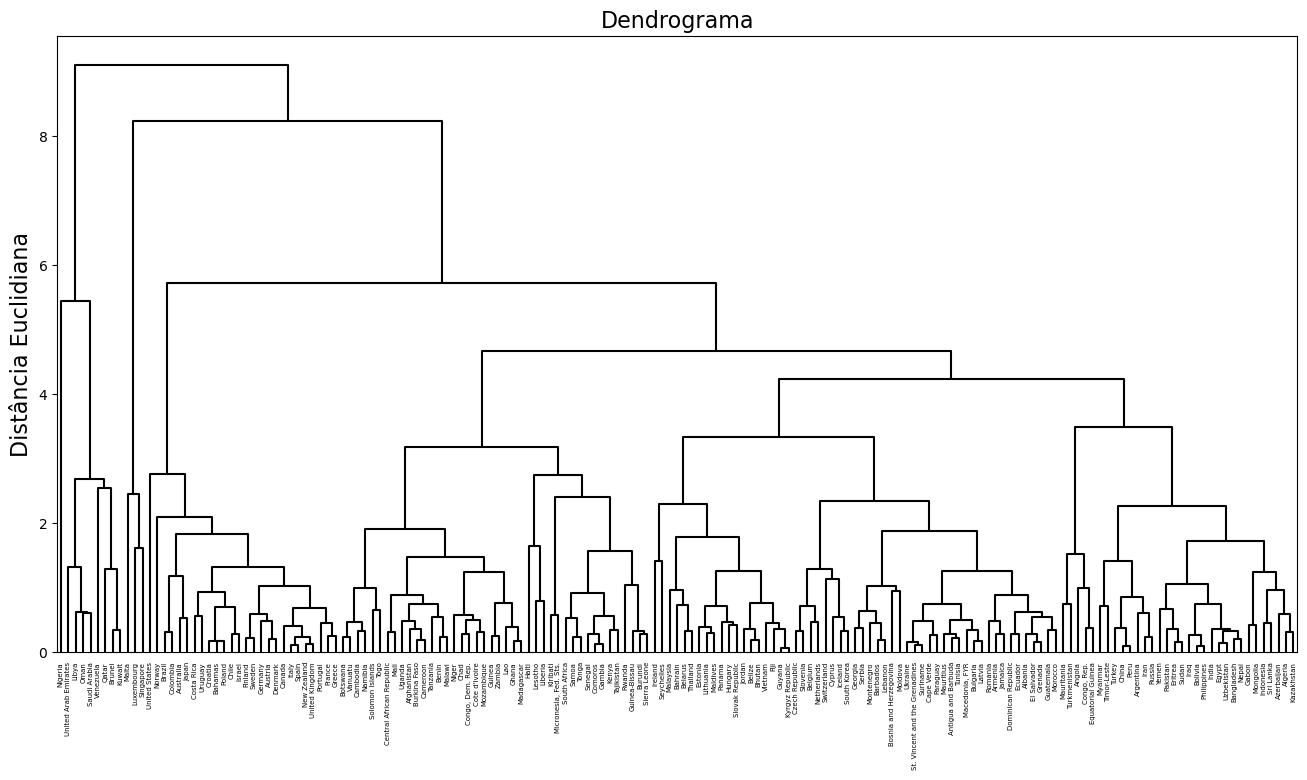

In [26]:
# 1º Teste: Elaboração da clusterização hierárquica como "complete linkage"


plt.figure(figsize=(16,8))
sch.set_link_color_palette(['black'])
dendrogram = sch.dendrogram(sch.linkage(df_cluster.iloc[:, 1:], method = 'complete', metric = 'euclidean'), labels = list(df_cluster.country), above_threshold_color = 'black')
plt.title('Dendrograma', fontsize=16)
#plt.xlabel('Pessoas', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
#plt.axhline(y = 4.5, color = 'red', linestyle = '--')
plt.show()

## O método de encadeamento single linkage não permite uma clusterização útil
## Pode-se interpretar que as observações estão muito próximas umas das outras

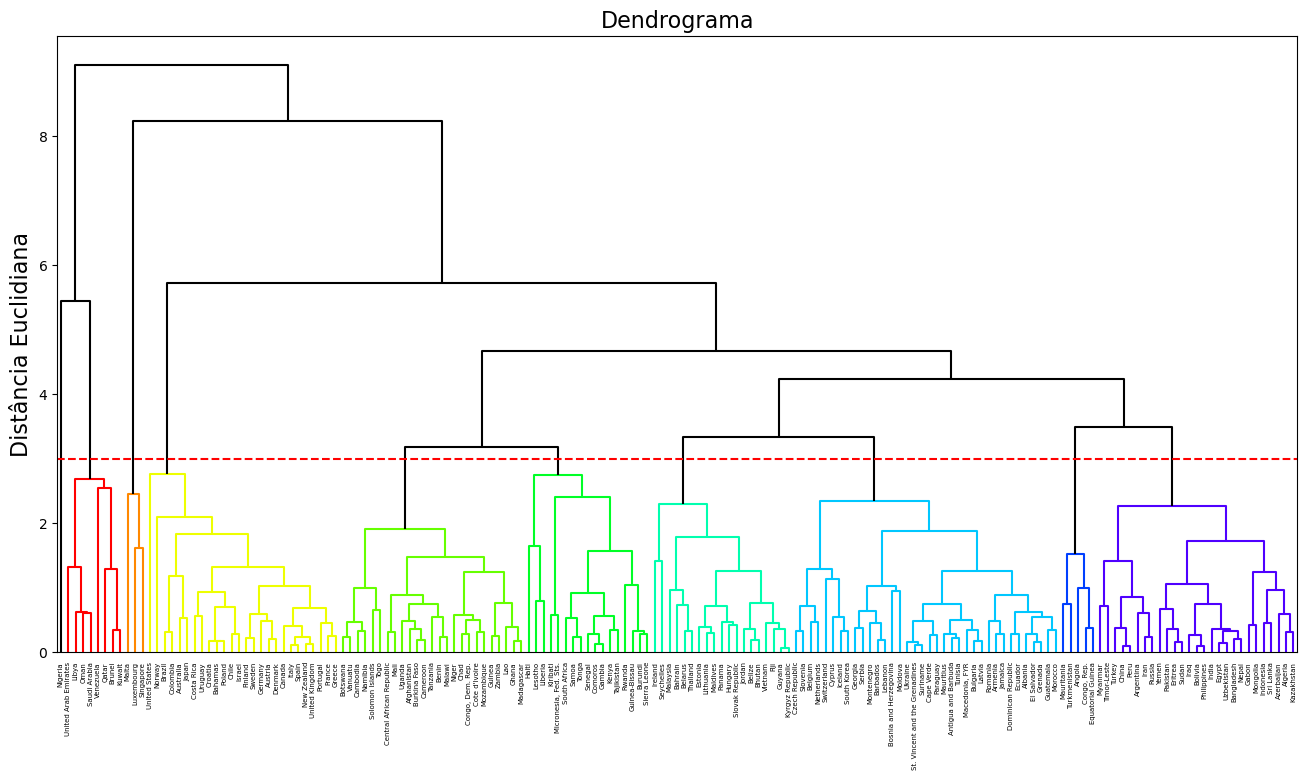

In [27]:

# Dendrograma com visualização dos clusters (definição de 10 clusters)

import matplotlib.cm as cm
import matplotlib as mpl

# Definir a paleta de cores
cmap = cm.hsv(np.linspace(0, 1, 12))



plt.figure(figsize=(16,8))
sch.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
dendrogram = sch.dendrogram(sch.linkage(df_cluster.iloc[:, 1:], method = 'complete', metric = 'euclidean'), labels = list(df_cluster.country), color_threshold = 3, above_threshold_color = 'black')
plt.title('Dendrograma', fontsize=16)
#plt.xlabel('Pessoas', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y = 3, color = 'red', linestyle = '--')
plt.show()


# As folhas com cor preta representam clusters únicos

In [28]:
# Vamos gerar uma variável indicando 12 clusters

clusters = AgglomerativeClustering(n_clusters = None, distance_threshold = 3, metric = 'euclidean', linkage = 'complete', compute_distances=False)
indica_clusters = clusters.fit_predict(df_cluster.iloc[:, 1:])


df['cluster_H'] = indica_clusters
df_cluster['cluster_H'] = indica_clusters

print(indica_clusters, "\n")


print(df.head(10))

[4 5 6 7 5 6 5 0 0 6 0 8 6 5 8 5 8 4 8 6 5 4 0 3 5 4 1 4 4 0 5 4 4 0 6 0 1
 4 7 0 4 0 5 5 0 5 5 6 5 7 6 8 8 0 0 6 1 5 0 4 0 5 5 4 1 8 1 8 5 6 6 6 6 8
 0 0 5 0 8 6 1 1 3 8 4 5 5 1 1 3 8 2 5 4 4 8 8 4 2 7 5 1 5 6 5 5 4 6 4 6 5
 0 4 9 0 3 6 8 5 6 6 0 0 3 5 6 1 1 3 1 5 8 1 2 8 5 4 1 5 0 6 5 6 5 0 5 1 4
 8 6 4 1 5 6 7 4 5 3 0 0 0 6 4 3 8 6 4] 

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
5            Argentina        14.5     18.9    8.10     16.0   18700   
6              Armenia        18.1     20.8    4.40     45.3    6700   
7            Australia         4.8     19.8    8.73     20.9   41400   
8         

/tmp/ipykernel_83091/2408944914.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster_H'] = indica_clusters


In [29]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# ANOVA


columns = df_cluster.columns.values[1:-1]
for column in columns:
    print(column)
    formula = column + ' ~ C(cluster_H)'
    model = ols(formula, data=df_cluster).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    aov_table = aov_table
    print(aov_table, '\n')
    
## Todas auxiliam na formação de pelo menos um cluster

Fator_1
                  sum_sq     df          F        PR(>F)
C(cluster_H)  127.263319    9.0  55.868731  1.800870e-44
Residual       39.736681  157.0        NaN           NaN 

Fator_2
                  sum_sq     df          F        PR(>F)
C(cluster_H)  135.046181    9.0  73.725323  8.180003e-52
Residual       31.953819  157.0        NaN           NaN 

Fator_3
                  sum_sq     df          F        PR(>F)
C(cluster_H)  127.425292    9.0  56.168788  1.312609e-44
Residual       39.574708  157.0        NaN           NaN 



In [30]:
# Algumas estatísticas descritivas entre clusters

# PIB

analise = df.groupby('cluster_H')['gdpp'].agg(['mean', 'std', 'min', 'max', 'count'])

analise


,mean,std,min,max,count
cluster_H,,,,,
0,34201.923077,19047.354046,6250,87800,26
1,1562.647059,1811.786616,231,7280,17
2,57566.666667,43011.665084,21100,105000,3
3,30412.500000,19159.886482,12100,70300,8
4,1254.760000,1477.085596,334,6350,25
5,13079.444444,16293.511232,1630,74600,36
6,4025.555556,3298.358348,482,10700,27
7,5802.000000,6426.820365,1200,17100,5
8,10049.473684,10864.358381,880,48700,19


In [31]:
# Indicador de saúde
analise = df.groupby('cluster_H')['health'].agg(['mean', 'std', 'min', 'max', 'count'])

analise


,mean,std,min,max,count
cluster_H,,,,,
0,9.847692,2.132531,7.46,17.90,26
1,8.592941,3.196730,4.51,14.20,17
2,6.793333,2.492877,3.96,8.65,3
3,3.348750,1.012824,1.81,4.91,8
4,5.948800,1.505139,3.77,9.01,25
5,7.488333,2.188746,4.09,11.90,36
6,4.892593,1.816898,1.97,9.12,27
7,3.340000,1.020368,2.46,4.48,5
8,6.145263,1.630485,3.40,9.19,19


In [32]:
# Expectativa de vida
analise = df.groupby('cluster_H')['life_expec'].agg(['mean', 'std', 'min', 'max', 'count'])

analise


,mean,std,min,max,count
cluster_H,,,,,
0,79.542308,2.460922,73.8,82.8,26
1,60.111765,9.699735,32.1,71.5,17
2,81.433333,1.205543,80.3,82.7,3
3,76.750000,1.475514,75.1,79.5,8
4,58.200000,3.959061,47.5,66.1,25
5,75.425000,3.420307,69.7,82.2,36
6,69.937037,4.332449,61.7,78.2,27
7,63.500000,4.164733,60.1,68.2,5
8,73.573684,4.022415,65.3,80.4,19


# Exemplo 2: Segmentação

In [33]:
# Importando os pacotes - gerais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Importando os pacotes - clusterização
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import scipy.stats as stats
from sklearn.cluster import KMeans


# Importando os pacotes - Anacor
import prince
from scipy.stats import chi2_contingency
import math

## 2.1. Base de dados

In [34]:
# pip install pyreadr

In [35]:
# Importando os dados
import pyreadr

result = pyreadr.read_r('datasets/segmenta.Rdata') 
print(result.keys())

odict_keys(['segmenta'])


In [36]:
df = result["segmenta"]


In [37]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size
0,Male,No,22,No,Low,4.0
1,Female,Yes,38,Yes,Average,3.0
2,Female,Yes,67,Yes,Low,1.0
3,Male,Yes,67,Yes,High,2.0
4,Female,Yes,40,Yes,High,6.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          8068 non-null   object 
 1   Ever_Married    7928 non-null   object 
 2   Age             8068 non-null   int32  
 3   Graduated       7990 non-null   object 
 4   Spending_Score  8068 non-null   object 
 5   Family_Size     7733 non-null   float64
dtypes: float64(1), int32(1), object(4)
memory usage: 346.8+ KB


In [39]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size
count,8068,7928,8068.000000,7990,8068,7733.000000
unique,2,2,NaN,2,3,NaN
top,Male,Yes,NaN,Yes,Low,NaN
freq,4417,4643,NaN,4968,4878,NaN
mean,NaN,NaN,43.466906,NaN,NaN,2.850123
std,NaN,NaN,16.711696,NaN,NaN,1.531413
min,NaN,NaN,18.000000,NaN,NaN,1.000000
25%,NaN,NaN,30.000000,NaN,NaN,2.000000
50%,NaN,NaN,40.000000,NaN,NaN,3.000000
75%,NaN,NaN,53.000000,NaN,NaN,4.000000


In [40]:
# Como existem variáveis com missing values (NAs), vamos excluir as observações
df_dropna = df.dropna()

In [41]:
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7538 entries, 0 to 8067
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          7538 non-null   object 
 1   Ever_Married    7538 non-null   object 
 2   Age             7538 non-null   int32  
 3   Graduated       7538 non-null   object 
 4   Spending_Score  7538 non-null   object 
 5   Family_Size     7538 non-null   float64
dtypes: float64(1), int32(1), object(4)
memory usage: 382.8+ KB


In [42]:
# Estatísticas descritivas
summary = df_dropna.describe(include = 'all')
summary


,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size
count,7538,7538,7538.000000,7538,7538,7538.000000
unique,2,2,NaN,2,3,NaN
top,Male,Yes,NaN,Yes,Low,NaN
freq,4163,4466,NaN,4731,4504,NaN
mean,NaN,NaN,43.524144,NaN,NaN,2.845450
std,NaN,NaN,16.612202,NaN,NaN,1.527899
min,NaN,NaN,18.000000,NaN,NaN,1.000000
25%,NaN,NaN,31.000000,NaN,NaN,2.000000
50%,NaN,NaN,41.000000,NaN,NaN,3.000000
75%,NaN,NaN,53.000000,NaN,NaN,4.000000


In [43]:
# Algumas variáveis são qualitativas e outras são quantitativas
# Vamos separar o banco de dados em 2 partes (somente quali e quanti)

segmenta_quali = df_dropna[['Gender', 'Ever_Married', 'Graduated', 'Spending_Score']]
segmenta_quanti = df_dropna[['Age', 'Family_Size']]


In [44]:
# Estatísticas descritivas
summary = segmenta_quali.describe(include = 'all')
summary

,Gender,Ever_Married,Graduated,Spending_Score
count,7538,7538,7538,7538
unique,2,2,2,3
top,Male,Yes,Yes,Low
freq,4163,4466,4731,4504


In [45]:
# Estatísticas descritivas
summary = segmenta_quanti.describe(include = 'all')
summary

,Age,Family_Size
count,7538.000000,7538.000000
mean,43.524144,2.845450
std,16.612202,1.527899
min,18.000000,1.000000
25%,31.000000,2.000000
50%,41.000000,3.000000
75%,53.000000,4.000000
max,89.000000,9.000000


In [46]:
# Aplicando a padronização por ZScore

from sklearn.preprocessing import scale
segmenta_quanti = pd.DataFrame(scale(segmenta_quanti),
                     index=segmenta_quanti.index,
                     columns=segmenta_quanti.columns)

print(segmenta_quanti.head(5), '\n')
print(segmenta_quanti.describe(include = 'all'))

        Age  Family_Size
0 -1.295769     0.755696
1 -0.332557     0.101159
2  1.413263    -1.207915
3  1.413263    -0.553378
4 -0.212156     2.064769 

                Age   Family_Size
count  7.538000e+03  7.538000e+03
mean  -2.335695e-16  1.168290e-16
std    1.000066e+00  1.000066e+00
min   -1.536572e+00 -1.207915e+00
25%   -7.539624e-01 -5.533779e-01
50%   -1.519553e-01  1.011588e-01
75%    5.704532e-01  7.556956e-01
max    2.737679e+00  4.028380e+00


## 2.2. Clusterização não-hierárquica KMeans

/home/hiro/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hiro/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hiro/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hiro/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hiro/anaconda3/lib/python3

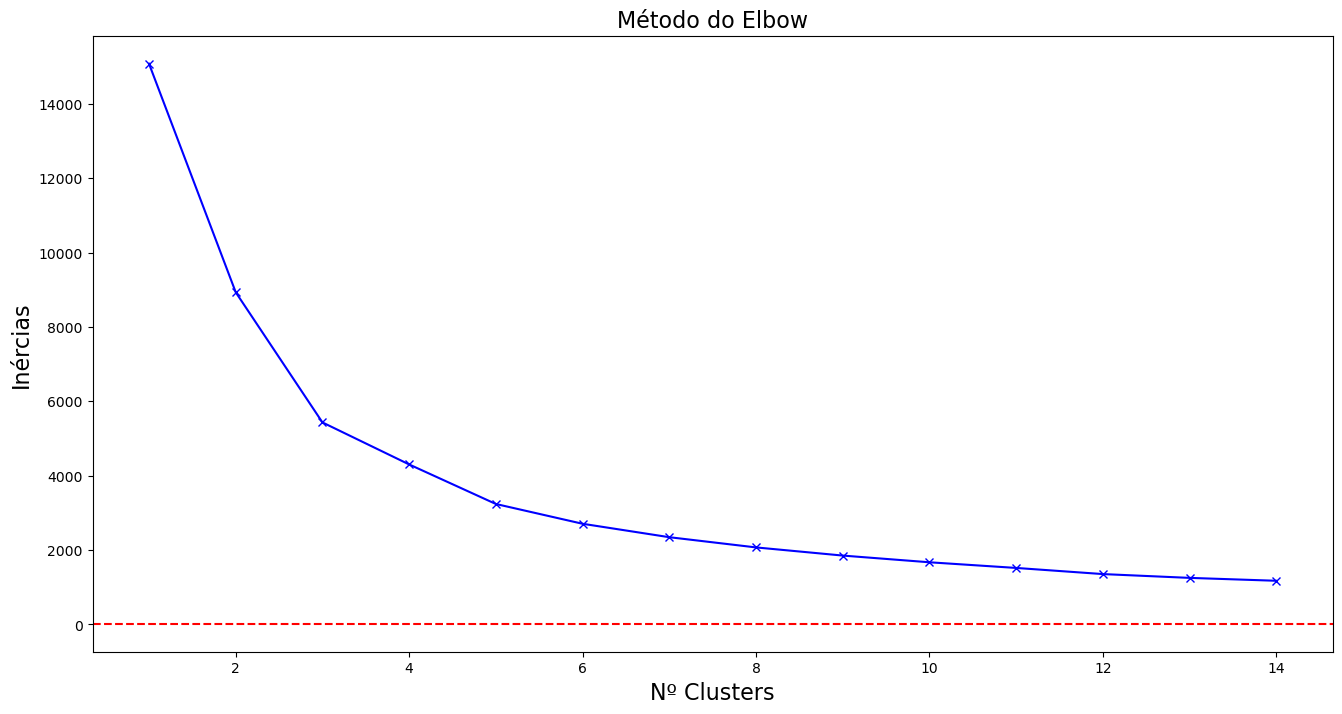

In [47]:
# Identificação da quantidade de clusters

# Método Elbow para identificação do nº de clusters
## Elaborado com base na "inércia": distância de cada obervação para o centróide de seu cluster
## Quanto mais próximos entre si e do centróide, menor a inércia

inercias = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(segmenta_quanti)
    inercias.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inercias, 'bx-')
plt.axhline(y = 20, color = 'red', linestyle = '--')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Inércias', fontsize=16)
plt.title('Método do Elbow', fontsize=16)
plt.show()

# Normalmente, busca-se o "cotovelo", ou seja, o ponto onde a curva "dobra"

In [48]:
# Elaboração da clusterização não hieráquica k-means

kmeans = KMeans(n_clusters = 5, init = 'random').fit(segmenta_quanti)

/home/hiro/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
#%% Para identificarmos os clusters gerados

kmeans_clusters = kmeans.labels_

print(kmeans_clusters)

df_dropna['cluster_kmeans'] = kmeans_clusters
segmenta_quanti['cluster_kmeans'] = kmeans_clusters
segmenta_quali['cluster_kmeans'] = kmeans_clusters


print(df_dropna.head(5))

[4 4 3 ... 1 4 4]
   Gender Ever_Married  Age Graduated Spending_Score  Family_Size  \
0    Male           No   22        No            Low          4.0   
1  Female          Yes   38       Yes        Average          3.0   
2  Female          Yes   67       Yes            Low          1.0   
3    Male          Yes   67       Yes           High          2.0   
4  Female          Yes   40       Yes           High          6.0   

   cluster_kmeans  
0               4  
1               4  
2               3  
3               3  
4               0  


/tmp/ipykernel_83091/901908214.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['cluster_kmeans'] = kmeans_clusters
/tmp/ipykernel_83091/901908214.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmenta_quali['cluster_kmeans'] = kmeans_clusters


In [50]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# ANOVA


columns = segmenta_quanti.columns.values[:-1]
for column in columns:
    print(column)
    formula = column + ' ~ C(cluster_kmeans)'
    model = ols(formula, data=segmenta_quanti).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    aov_table = aov_table
    print(aov_table, '\n')
    
## Todas auxiliam na formação de pelo menos um cluster

Age
                        sum_sq      df            F  PR(>F)
C(cluster_kmeans)  5735.928307     4.0  5994.315892     0.0
Residual           1802.071693  7533.0          NaN     NaN 

Family_Size
                        sum_sq      df            F  PR(>F)
C(cluster_kmeans)  6100.998996     4.0  7995.614707     0.0
Residual           1437.001004  7533.0          NaN     NaN 



In [51]:
segmenta_quanti.columns.values[:-1]

array(['Age', 'Family_Size'], dtype=object)

In [52]:
# Algumas estatísticas descritivas entre clusters

# Age

analise = df_dropna.groupby('cluster_kmeans')['Age'].agg(['mean', 'std', 'min', 'max', 'count'])

analise


,mean,std,min,max,count
cluster_kmeans,,,,,
0,30.911765,9.519366,18,69,782
1,38.561439,7.856455,18,53,2474
2,51.702177,7.373680,40,85,1286
3,70.043575,9.814933,55,89,1354
4,28.735079,6.698056,18,41,1642


In [53]:
# Age

analise = df_dropna.groupby('cluster_kmeans')['Age'].agg(['mean', 'std', 'min', 'max', 'count'])

analise

,mean,std,min,max,count
cluster_kmeans,,,,,
0,30.911765,9.519366,18,69,782
1,38.561439,7.856455,18,53,2474
2,51.702177,7.373680,40,85,1286
3,70.043575,9.814933,55,89,1354
4,28.735079,6.698056,18,41,1642


In [54]:
# Family_Size

analise = df_dropna.groupby('cluster_kmeans')['Family_Size'].agg(['mean', 'std', 'min', 'max', 'count'])

analise

,mean,std,min,max,count
cluster_kmeans,,,,,
0,5.870844,1.163880,5.0,9.0,782
1,1.592158,0.491533,1.0,2.0,2474
2,3.786936,0.751455,3.0,7.0,1286
3,1.790990,0.591795,1.0,4.0,1354
4,3.425091,0.551595,2.0,4.0,1642


In [55]:
# Gender


# Agrupar os dados por cluster_K e contar a ocorrência de cada valor em Gender
analise = df_dropna.groupby(['cluster_kmeans', 'Gender']).size().reset_index(name='count')

# Calcular a proporção para cada valor em Gender dentro de cada cluster_K
analise['prop'] = analise.groupby('cluster_kmeans')['count'].transform(lambda x: x / x.sum())


analise

,cluster_kmeans,Gender,count,prop
0,0,Female,356,0.455243
1,0,Male,426,0.544757
2,1,Female,1291,0.521827
3,1,Male,1183,0.478173
4,2,Female,483,0.375583
5,2,Male,803,0.624417
6,3,Female,558,0.412112
7,3,Male,796,0.587888
8,4,Female,687,0.418392
9,4,Male,955,0.581608


In [56]:
# Ever_Maried



analise = df_dropna.groupby(['cluster_kmeans', 'Ever_Married']).size().reset_index(name='count')

analise['prop'] = analise.groupby('cluster_kmeans')['count'].transform(lambda x: x / x.sum())


analise

,cluster_kmeans,Ever_Married,count,prop
0,0,No,539,0.689258
1,0,Yes,243,0.310742
2,1,No,1162,0.469685
3,1,Yes,1312,0.530315
4,2,No,78,0.060653
5,2,Yes,1208,0.939347
6,3,No,99,0.073117
7,3,Yes,1255,0.926883
8,4,No,1194,0.727162
9,4,Yes,448,0.272838


In [57]:
# Ever_Maried



analise = df_dropna.groupby(['cluster_kmeans', 'Graduated']).size().reset_index(name='count')

analise['prop'] = analise.groupby('cluster_kmeans')['count'].transform(lambda x: x / x.sum())


analise

,cluster_kmeans,Graduated,count,prop
0,0,No,504,0.644501
1,0,Yes,278,0.355499
2,1,No,565,0.228375
3,1,Yes,1909,0.771625
4,2,No,326,0.253499
5,2,Yes,960,0.746501
6,3,No,429,0.316839
7,3,Yes,925,0.683161
8,4,No,983,0.598660
9,4,Yes,659,0.401340


In [58]:
# Ever_Maried



analise = df_dropna.groupby(['cluster_kmeans', 'Spending_Score']).size().reset_index(name='count')

analise['prop'] = analise.groupby('cluster_kmeans')['count'].transform(lambda x: x / x.sum())


analise

,cluster_kmeans,Spending_Score,count,prop
0,0,Average,120,0.153453
1,0,High,74,0.094629
2,0,Low,588,0.751918
3,1,Average,598,0.241714
4,1,High,123,0.049717
5,1,Low,1753,0.708569
6,2,Average,690,0.536547
7,2,High,331,0.257387
8,2,Low,265,0.206065
9,3,Average,242,0.178730


## 2.3. Anacor Múltipla

### - Análises Preliminares

In [59]:
segmenta_quali.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7538 entries, 0 to 8067
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          7538 non-null   object
 1   Ever_Married    7538 non-null   object
 2   Graduated       7538 non-null   object
 3   Spending_Score  7538 non-null   object
 4   cluster_kmeans  7538 non-null   int32 
dtypes: int32(1), object(4)
memory usage: 323.9+ KB


In [60]:
segmenta_quali['cluster_kmeans'] = segmenta_quali['cluster_kmeans'].astype('object')
segmenta_quali.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7538 entries, 0 to 8067
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          7538 non-null   object
 1   Ever_Married    7538 non-null   object
 2   Graduated       7538 non-null   object
 3   Spending_Score  7538 non-null   object
 4   cluster_kmeans  7538 non-null   object
dtypes: object(5)
memory usage: 353.3+ KB


/tmp/ipykernel_83091/3237907299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmenta_quali['cluster_kmeans'] = segmenta_quali['cluster_kmeans'].astype('object')


In [61]:
tabela_contingencia1 = pd.crosstab(index=segmenta_quali['Spending_Score'], columns=segmenta_quali['Gender'])
tabela_contingencia1

Gender,Female,Male
Spending_Score,,
Average,791,1097
High,455,691
Low,2129,2375


In [62]:
tabela_contingencia2 = pd.crosstab(index=segmenta_quali['Spending_Score'], columns=segmenta_quali['Ever_Married'])
tabela_contingencia2

Ever_Married,No,Yes
Spending_Score,,
Average,0,1888
High,0,1146
Low,3072,1432


In [63]:
tabela_contingencia3 = pd.crosstab(index=segmenta_quali['Spending_Score'], columns=segmenta_quali['Graduated'])
tabela_contingencia3

Graduated,No,Yes
Spending_Score,,
Average,477,1411
High,396,750
Low,1934,2570


In [64]:
tabela_contingencia4 = pd.crosstab(index=segmenta_quali['Spending_Score'], columns=segmenta_quali['cluster_kmeans'])
tabela_contingencia4

cluster_kmeans,0,1,2,3,4
Spending_Score,,,,,
Average,120,598,690,242,238
High,74,123,331,514,104
Low,588,1753,265,598,1300


In [65]:
#%% Analisando a significância estatística da associação (teste qui²)
# Se o p valor é menor que 0.05 então se rejeita  hipótese nula, isto é, que as variáveis não 
# tem associação estatisticamente relevantes.

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia1)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia2)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia3)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia4)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} ") # graus de liberdade

estatística qui²: 29.579826999283174
p-valor da estatística: 3.7741762664099686e-07
graus de liberdade: 2 

estatística qui²: 3492.816905150341
p-valor da estatística: 0.0
graus de liberdade: 2 

estatística qui²: 181.9858645881994
p-valor da estatística: 3.0357892060850624e-40
graus de liberdade: 2 

estatística qui²: 1949.3818993584784
p-valor da estatística: 0.0
graus de liberdade: 8 


### - Processo pelo Prince

In [66]:
#%% Elaborando a MCA 

## Utiliza o método da matriz de Burt

mca = prince.MCA()
mca = mca.fit(segmenta_quali)

/home/hiro/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [67]:
#%% Obtendo as coordenadas nas duas dimensões do mapa

mca.column_coordinates(segmenta_quali)

/home/hiro/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,0,1
Gender_Female,-0.157788,-0.340418
Gender_Male,0.127921,0.275982
Ever_Married_No,-1.064475,-0.081051
Ever_Married_Yes,0.732214,0.055752
Graduated_No,-0.504885,0.720693
Graduated_Yes,0.299559,-0.427602
Spending_Score_Average,0.944106,-0.582699
Spending_Score_High,1.076733,1.257503
Spending_Score_Low,-0.669717,-0.075702
cluster_kmeans_0,-0.816838,0.694068


In [68]:
#%% Obtendo as coordenadas de cada um das observações

mca.row_coordinates(segmenta_quali)




/home/hiro/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,0,1
0,-0.904156,0.510633
1,0.279298,-0.311508
2,0.295891,0.076240
3,0.907959,0.827029
4,0.341514,0.477253
...,...,...
8063,-0.881886,0.590736
8064,-0.904156,0.510633
8065,-0.532076,-0.744415
8066,-0.747918,-0.168948


In [69]:
#%% Obtendo os eigenvalues

mca.eigenvalues_



[0.44093605697678306, 0.26972303133254244]

In [70]:
#%% Inércia principal total

mca.total_inertia_



1.8

In [71]:
#%% Obtendo a variância

mca.explained_inertia_

[0.2449644760982128, 0.14984612851807913]

/home/hiro/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/hiro/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


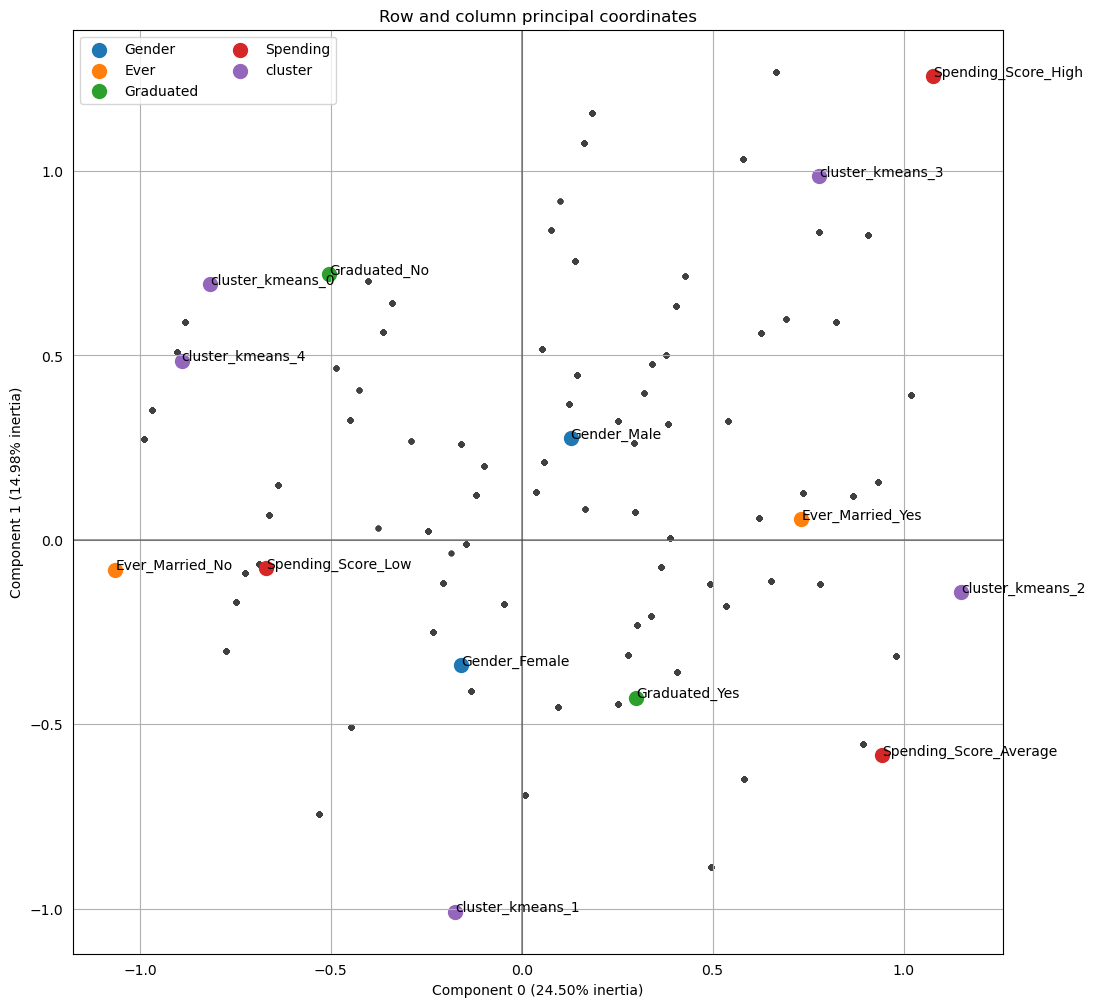

In [72]:
#%% Plotando o mapa perceptual

mp_mca = mca.plot_coordinates(
             X = segmenta_quali,
             figsize=(12,12),
             show_row_points = True,
             show_column_points = True,
             show_row_labels=False,
             column_points_size = 100,
             show_column_labels = True,
             legend_n_cols = 2)

# Exemplo 3: Casas

## 3.1. Base de dados

In [124]:
# Importando os dados

df = pd.read_excel("datasets/preco_casas.xlsx")

In [125]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size_class,property_value
0,201,177,3,1,No,Yes,Yes,No,3.3,Yes,10,No,6.8,0.90,Zero,165432
1,196,182,4,3,Yes,Yes,No,Yes,1.2,Yes,11,No,4.1,1.42,One,187043
2,198,182,4,4,Yes,Yes,No,Yes,5.9,No,20,No,2.1,4.12,One,148658
3,178,166,2,3,No,Yes,No,No,5.9,No,5,No,0.7,4.36,Zero,123785
4,183,165,3,1,Yes,Yes,No,No,3.8,Yes,8,No,0.7,0.42,Zero,156470


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   land_size_sqm               4954 non-null   int64  
 1   house_size_sqm              4954 non-null   int64  
 2   no_of_rooms                 4954 non-null   int64  
 3   no_of_bathrooms             4954 non-null   int64  
 4   large_living_room           4954 non-null   object 
 5   parking_space               4954 non-null   object 
 6   front_garden                4954 non-null   object 
 7   swimming_pool               4954 non-null   object 
 8   distance_to_school          4954 non-null   float64
 9   wall_fence                  4954 non-null   object 
 10  house_age                   4954 non-null   int64  
 11  water_front                 4954 non-null   object 
 12  distance_to_supermarket_km  4954 non-null   float64
 13  crime_rate_index            4954 

In [127]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size_class,property_value
count,4954.000000,4954.000000,4954.000000,4954.000000,4954,4954,4954,4954,4954.000000,4954,4954.000000,4954,4954.000000,4954.000000,4954,4954.000000
unique,NaN,NaN,NaN,NaN,2,2,2,2,NaN,2,NaN,2,NaN,NaN,4,NaN
top,NaN,NaN,NaN,NaN,Yes,Yes,Yes,Yes,NaN,Yes,NaN,No,NaN,NaN,Two,NaN
freq,NaN,NaN,NaN,NaN,3586,3784,3109,3060,NaN,3123,NaN,4713,NaN,NaN,1779,NaN
mean,250.131409,231.250908,3.788252,3.199839,NaN,NaN,NaN,NaN,3.454219,NaN,11.444691,NaN,3.508639,2.986110,NaN,201974.738999
std,103.131939,94.571642,1.585371,1.602300,NaN,NaN,NaN,NaN,2.007358,NaN,6.356991,NaN,1.991266,1.737742,NaN,90031.882219
min,100.000000,85.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,0.100000,NaN,1.000000,NaN,0.100000,0.010000,NaN,32622.000000
25%,180.000000,165.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,1.700000,NaN,6.000000,NaN,1.800000,1.470000,NaN,136777.000000
50%,235.000000,217.500000,4.000000,3.000000,NaN,NaN,NaN,NaN,3.400000,NaN,11.000000,NaN,3.500000,3.020000,NaN,194515.500000
75%,295.000000,274.000000,5.000000,4.000000,NaN,NaN,NaN,NaN,5.200000,NaN,17.000000,NaN,5.300000,4.490000,NaN,246590.000000


In [128]:
# Algumas variáveis são qualitativas e outras são quantitativas
# Vamos separar o banco de dados em 2 partes (somente quali e quanti)

var_quali = df[['large_living_room', 'parking_space', 'front_garden', 'swimming_pool', 'wall_fence', 'water_front', 'room_size_class']]
var_quanti = df[['land_size_sqm', 'house_size_sqm', 'no_of_rooms', 'no_of_bathrooms', 'distance_to_school', 'house_age', 'distance_to_supermarket_km', 'crime_rate_index']]

## Nota: vamos deixar a variável "valor da casa" fora da análise por enquanto
## O objetivo é criar um ranking que capture os valores das casas

In [129]:
# Estatísticas descritivas
summary = var_quali.describe(include = 'all')
summary


,large_living_room,parking_space,front_garden,swimming_pool,wall_fence,water_front,room_size_class
count,4954,4954,4954,4954,4954,4954,4954
unique,2,2,2,2,2,2,4
top,Yes,Yes,Yes,Yes,Yes,No,Two
freq,3586,3784,3109,3060,3123,4713,1779


In [130]:
# Estatísticas descritivas
summary = var_quanti.describe(include = 'all')
summary


,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,distance_to_school,house_age,distance_to_supermarket_km,crime_rate_index
count,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000
mean,250.131409,231.250908,3.788252,3.199839,3.454219,11.444691,3.508639,2.986110
std,103.131939,94.571642,1.585371,1.602300,2.007358,6.356991,1.991266,1.737742
min,100.000000,85.000000,1.000000,1.000000,0.100000,1.000000,0.100000,0.010000
25%,180.000000,165.000000,3.000000,2.000000,1.700000,6.000000,1.800000,1.470000
50%,235.000000,217.500000,4.000000,3.000000,3.400000,11.000000,3.500000,3.020000
75%,295.000000,274.000000,5.000000,4.000000,5.200000,17.000000,5.300000,4.490000
max,796.000000,760.000000,8.000000,9.000000,6.900000,22.000000,6.900000,5.990000


## 3.2. Anacor Múltipla

### - Análises Preliminares

In [131]:
var_quali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   large_living_room  4954 non-null   object
 1   parking_space      4954 non-null   object
 2   front_garden       4954 non-null   object
 3   swimming_pool      4954 non-null   object
 4   wall_fence         4954 non-null   object
 5   water_front        4954 non-null   object
 6   room_size_class    4954 non-null   object
dtypes: object(7)
memory usage: 271.0+ KB


In [132]:
tabela_contingencia1 = pd.crosstab(index=var_quali['large_living_room'], columns=var_quali['parking_space'])
tabela_contingencia1

parking_space,No,Yes
large_living_room,,
No,572,796
Yes,598,2988


In [133]:
tabela_contingencia2 = pd.crosstab(index=var_quali['large_living_room'], columns=var_quali['front_garden'])
tabela_contingencia2

front_garden,No,Yes
large_living_room,,
No,862,506
Yes,983,2603


In [134]:
tabela_contingencia3 = pd.crosstab(index=var_quali['large_living_room'], columns=var_quali['swimming_pool'])
tabela_contingencia3

swimming_pool,No,Yes
large_living_room,,
No,858,510
Yes,1036,2550


In [135]:
tabela_contingencia4 = pd.crosstab(index=var_quali['large_living_room'], columns=var_quali['wall_fence'])
tabela_contingencia4

wall_fence,No,Yes
large_living_room,,
No,794,574
Yes,1037,2549


In [136]:
tabela_contingencia5 = pd.crosstab(index=var_quali['large_living_room'], columns=var_quali['water_front'])
tabela_contingencia5

water_front,No,Yes
large_living_room,,
No,1322,46
Yes,3391,195


In [137]:
tabela_contingencia6 = pd.crosstab(index=var_quali['large_living_room'], columns=var_quali['room_size_class'])
tabela_contingencia6

room_size_class,One,Three,Two,Zero
large_living_room,,,,
No,469,219,452,228
Yes,991,979,1327,289


In [138]:
#%% Analisando a significância estatística da associação (teste qui²)
# Se o p valor é menor que 0.05 então se rejeita  hipótese nula, isto é, que as variáveis não 
# tem associação estatisticamente relevantes.

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia1)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia2)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia3)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia4)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia5)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia6)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} ") # graus de liberdade

estatística qui²: 345.4557677020062
p-valor da estatística: 4.1374124496644564e-77
graus de liberdade: 1 

estatística qui²: 535.4157732018284
p-valor da estatística: 1.8738256781928906e-118
graus de liberdade: 1 

estatística qui²: 478.44966948393864
p-valor da estatística: 4.646150272033343e-106
graus de liberdade: 1 

estatística qui²: 359.215174177864
p-valor da estatística: 4.1732849138450074e-80
graus de liberdade: 1 

estatística qui²: 8.771619299309906
p-valor da estatística: 0.003059537041679518
graus de liberdade: 1 

estatística qui²: 141.69820657799835
p-valor da estatística: 1.626599947711297e-30
graus de liberdade: 3 


### - Processo pelo Prince

In [139]:
#%% Elaborando a MCA 

## Utiliza o método da matriz de Burt

mca = prince.MCA()
mca = mca.fit(var_quali)

In [140]:
#%% Obtendo as coordenadas nas duas dimensões do mapa

mca.column_coordinates(var_quali)

,0,1
large_living_room_No,0.976380,-0.095572
large_living_room_Yes,-0.372473,0.036459
parking_space_No,1.205710,0.064914
parking_space_Yes,-0.372802,-0.020071
front_garden_No,0.909825,-0.019481
front_garden_Yes,-0.539925,0.011561
swimming_pool_No,0.886997,0.058291
swimming_pool_Yes,-0.549011,-0.036080
wall_fence_No,0.868065,0.036232
wall_fence_Yes,-0.508942,-0.021243


In [141]:
#%% Obtendo as coordenadas de cada um das observações

mca.row_coordinates(var_quali)




,0,1
0,0.369421,0.317828
1,-0.141592,-0.447006
2,0.189233,-0.425518
3,1.048545,0.327711
4,0.393661,0.355585
...,...,...
4949,-0.599403,0.104366
4950,-0.657489,1.374289
4951,-0.006458,-0.044800
4952,0.403782,0.064887


In [142]:
#%% Obtendo os eigenvalues

mca.eigenvalues_



[0.35357551029258566, 0.1460052787789108]

In [143]:
#%% Inércia principal total

mca.total_inertia_



1.2857142857142858

In [144]:
#%% Obtendo a variância

mca.explained_inertia_

[0.2750031746720111, 0.11355966127248618]

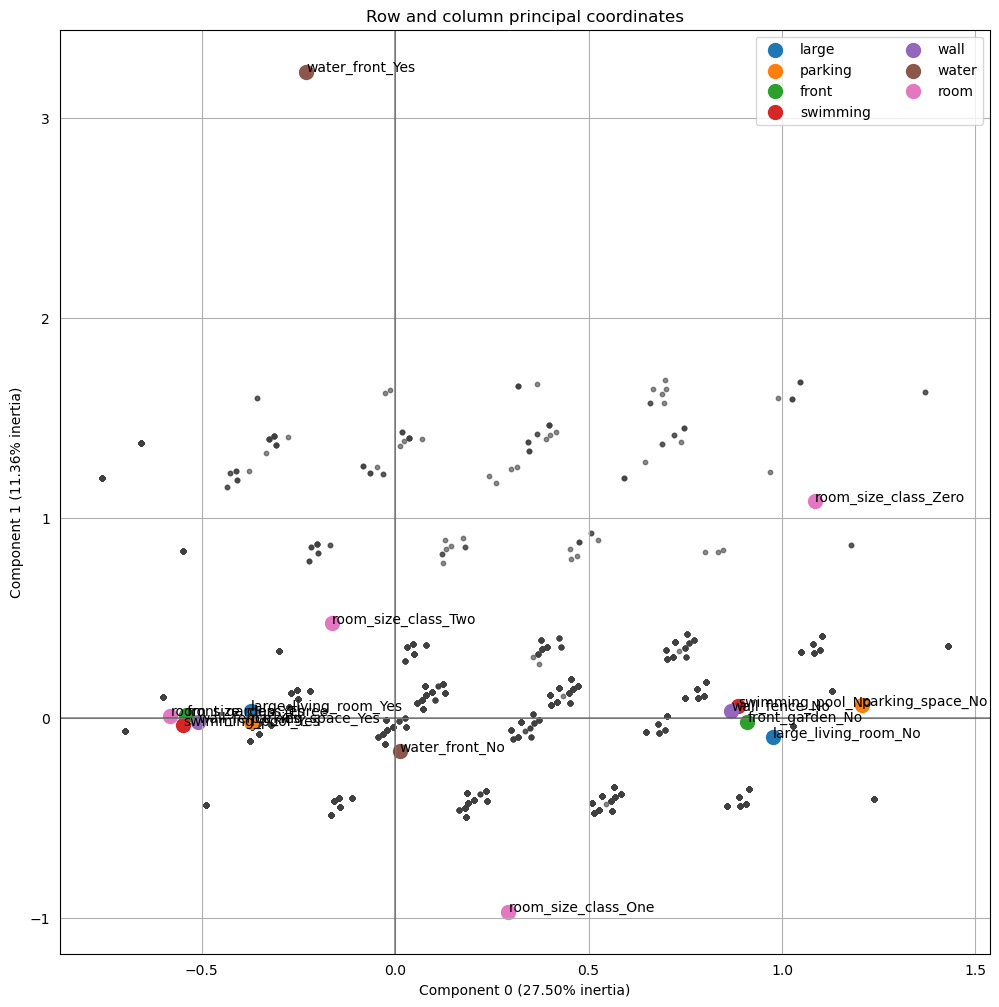

In [145]:
#%% Plotando o mapa perceptual

mp_mca = mca.plot_coordinates(
             X = var_quali,
             figsize=(12,12),
             show_row_points = True,
             show_column_points = True,
             show_row_labels=False,
             column_points_size = 100,
             show_column_labels = True,
             legend_n_cols = 2)

## 3.3. PCA

In [146]:
# Adicionando as coordenadas ao banco de dados de variáveis quantitativas
coord_obs = mca.row_coordinates(var_quali)
var_quanti['Axis1'] = coord_obs.iloc[:, 0]
var_quanti['Axis2'] = coord_obs.iloc[:, 1]

/tmp/ipykernel_83091/2683915793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_quanti['Axis1'] = coord_obs.iloc[:, 0]
/tmp/ipykernel_83091/2683915793.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_quanti['Axis2'] = coord_obs.iloc[:, 1]


In [147]:
var_quanti.head(5)

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,distance_to_school,house_age,distance_to_supermarket_km,crime_rate_index,Axis1,Axis2
0,201,177,3,1,3.3,10,6.8,0.90,0.369421,0.317828
1,196,182,4,3,1.2,11,4.1,1.42,-0.141592,-0.447006
2,198,182,4,4,5.9,20,2.1,4.12,0.189233,-0.425518
3,178,166,2,3,5.9,5,0.7,4.36,1.048545,0.327711
4,183,165,3,1,3.8,8,0.7,0.42,0.393661,0.355585


### 1º Passo: Correlação de Pearson

In [148]:
#%% Matriz de correlaçãoes entre as variáveis

matriz_corr = pg.rcorr(var_quanti, method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
matriz_corr


,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,distance_to_school,house_age,distance_to_supermarket_km,crime_rate_index,Axis1,Axis2
land_size_sqm,-,***,***,***,,,,,***,**
house_size_sqm,0.9914,-,***,***,,,,,***,**
no_of_rooms,0.8983,0.8948,-,***,,,,,***,
no_of_bathrooms,0.6798,0.6777,0.71,-,,,,,***,
distance_to_school,-0.0111,-0.0107,-0.0062,-0.0083,-,,,,,
house_age,0.0065,0.0082,0.0035,0.001,0.0115,-,,,,
distance_to_supermarket_km,0.0047,0.002,-0.0073,-0.0025,0.0101,-0.0028,-,,,
crime_rate_index,0.0078,0.008,0.0146,0.0107,-0.0021,-0.0007,0.018,-,,*
Axis1,-0.6663,-0.6605,-0.8062,-0.5554,0.0026,-0.0033,0.0119,-0.0046,-,
Axis2,0.0334,0.035,0.0115,0.0172,-0.0038,0.0031,0.0084,-0.0239,0.0,-


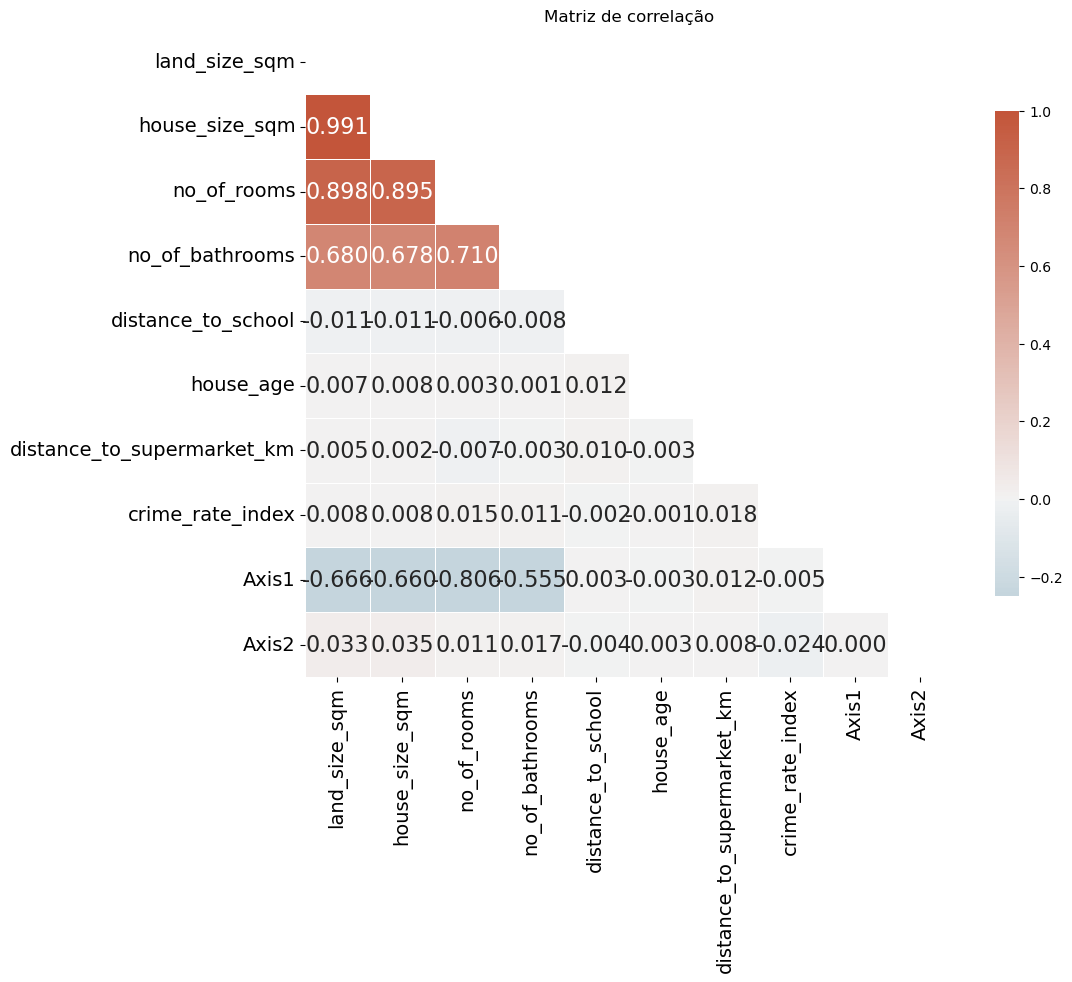

In [149]:
#%% Outra maneira de plotar as mesmas informações

corr = var_quanti.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, n=256, as_cmap=True)

sns.heatmap(var_quanti.corr(), 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin = -.25,
            center=0,
            square=True, 
            linewidths=.5,
            annot = True,
            fmt='.3f', 
            annot_kws={'size': 16},
            cbar_kws={"shrink": .75})

plt.title('Matriz de correlação')
plt.tight_layout()
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_ylim(len(corr))

plt.show()

### 2º Passo: Teste de Esferecidade de Bartlett

In [150]:
#%% Teste de Bartlett

bartlett, p_value = calculate_bartlett_sphericity(var_quanti)

print(f'Bartlett statistic: {bartlett}')

print(f'p-value : {p_value}')

Bartlett statistic: 37339.12325629857
p-value : 0.0


### 3º Passo: PCA

In [151]:
#%% Definindo a PCA (procedimento preliminar)

fa = FactorAnalyzer()
fa.fit(var_quanti)

FactorAnalyzer(rotation_kwargs={})

In [152]:
#%% Obtendo os Eigenvalues (autovalores)

ev, v = fa.get_eigenvalues()

print(ev)

# Temos 4 autovalores para este exemplo, pois são 4 variáveis

# Critério de Kaiser

# Verificar autovalores com valores maiores que 1
# Existem quatro componentes acima de 1


[4.0410849  1.027185   1.01473555 1.00711342 0.9892809  0.96253178
 0.45721138 0.4111426  0.08113185 0.00858261]


In [153]:
#%% Parametrizando a PCA para dois fatores (autovalores > 1)

fa.set_params(n_factors = 4, method = 'principal', rotation = None)
fa.fit(var_quanti)

FactorAnalyzer(method='principal', n_factors=4, rotation=None,
               rotation_kwargs={})

In [154]:
#%% Eigenvalues, variâncias e variâncias acumulada

eigen_fatores = fa.get_factor_variance()
eigen_fatores

tabela_eigen = pd.DataFrame(eigen_fatores)
tabela_eigen.columns = [f"Fator_{i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

tabela_eigen

,Autovalor,Variância,Variância Acumulada
Fator_1,4.041085,0.404108,0.404108
Fator_2,1.027185,0.102718,0.506827
Fator_3,1.014736,0.101474,0.608301
Fator_4,1.007113,0.100711,0.709012


In [155]:
#%% Determinando as cargas fatoriais

cargas_fatores = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatores)
tabela_cargas.columns = [f"Fator_{i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = var_quanti.columns
tabela_cargas

tabela_cargas

,Fator_1,Fator_2,Fator_3,Fator_4
land_size_sqm,0.951875,-0.007094,0.010473,0.012914
house_size_sqm,0.949457,-0.008913,0.010811,0.011206
no_of_rooms,0.963547,0.011446,-0.006694,-0.011874
no_of_bathrooms,0.798642,0.005552,-0.004742,0.002089
distance_to_school,-0.011664,0.126432,0.637139,-0.319483
house_age,0.006820,-0.068891,0.480943,-0.550164
distance_to_supermarket_km,-0.003965,0.354536,0.509616,0.608264
crime_rate_index,0.013363,0.739787,-0.042701,0.082176
Axis1,-0.816120,-0.012520,0.016249,0.031575
Axis2,0.029461,-0.577083,0.339695,0.473488


In [156]:
#%% Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = var_quanti.columns


tabela_comunalidades

,Comunalidades
land_size_sqm,0.906393
house_size_sqm,0.901791
no_of_rooms,0.928740
no_of_bathrooms,0.637887
distance_to_school,0.524137
house_age,0.538779
distance_to_supermarket_km,0.755405
crime_rate_index,0.556040
Axis1,0.667469
Axis2,0.673476


In [157]:
#%% Resultados dos fatores para as observações do dataset (predict)

predict_fatores= pd.DataFrame(fa.transform(var_quanti))
predict_fatores.columns =  [f"Fator_{i+1}" for i, v in enumerate(predict_fatores.columns)]

predict_fatores

,Fator_1,Fator_2,Fator_3,Fator_4
0,-0.762101,-0.767899,1.011815,1.450026
1,-0.199405,-0.011080,-0.957941,-0.071491
2,-0.181677,0.919471,0.638576,-2.022256
3,-0.971617,-0.205182,-0.148357,-0.165236
4,-0.839702,-2.026236,-0.477331,-0.285939
...,...,...,...,...
4949,0.521783,0.251517,0.669520,-0.315546
4950,0.375251,-2.150053,1.696834,1.912817
4951,-0.449374,0.733320,-0.160918,0.743864
4952,-1.017896,0.218834,-1.150751,1.193021


In [158]:
# Adicionando ao dataset 

df = pd.concat([df.reset_index(drop=True), predict_fatores], axis=1)

df

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size_class,property_value,Fator_1,Fator_2,Fator_3,Fator_4
0,201,177,3,1,No,Yes,Yes,No,3.3,Yes,10,No,6.8,0.90,Zero,165432,-0.762101,-0.767899,1.011815,1.450026
1,196,182,4,3,Yes,Yes,No,Yes,1.2,Yes,11,No,4.1,1.42,One,187043,-0.199405,-0.011080,-0.957941,-0.071491
2,198,182,4,4,Yes,Yes,No,Yes,5.9,No,20,No,2.1,4.12,One,148658,-0.181677,0.919471,0.638576,-2.022256
3,178,166,2,3,No,Yes,No,No,5.9,No,5,No,0.7,4.36,Zero,123785,-0.971617,-0.205182,-0.148357,-0.165236
4,183,165,3,1,Yes,Yes,No,No,3.8,Yes,8,No,0.7,0.42,Zero,156470,-0.839702,-2.026236,-0.477331,-0.285939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4949,297,261,4,4,Yes,Yes,Yes,Yes,2.9,Yes,20,No,4.1,3.99,Two,235882,0.521783,0.251517,0.669520,-0.315546
4950,302,282,4,2,Yes,Yes,Yes,Yes,3.8,Yes,12,Yes,4.8,2.09,Two,290995,0.375251,-2.150053,1.696834,1.912817
4951,153,147,3,4,Yes,Yes,No,No,3.3,Yes,7,No,4.7,3.98,Three,106428,-0.449374,0.733320,-0.160918,0.743864
4952,180,158,2,1,No,Yes,No,Yes,2.2,No,1,No,3.4,3.75,Two,107579,-1.017896,0.218834,-1.150751,1.193021


In [159]:
# Identificando os scores fatoriais

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator_{i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = var_quanti.columns

tabela_scores


,Fator_1,Fator_2,Fator_3,Fator_4
land_size_sqm,0.235549,-0.006906,0.010321,0.012822
house_size_sqm,0.234951,-0.008677,0.010654,0.011127
no_of_rooms,0.238438,0.011143,-0.006597,-0.011790
no_of_bathrooms,0.197631,0.005405,-0.004673,0.002074
distance_to_school,-0.002886,0.123086,0.627887,-0.317226
house_age,0.001688,-0.067068,0.473959,-0.546278
distance_to_supermarket_km,-0.000981,0.345153,0.502215,0.603968
crime_rate_index,0.003307,0.720208,-0.042081,0.081596
Axis1,-0.201956,-0.012189,0.016013,0.031352
Axis2,0.007290,-0.561810,0.334762,0.470144


In [161]:
#%% Correlação entre os fatores

# A seguir, verifica-se que a correlação entre os fatores é zero (ortogonais)

corr_fator = pg.rcorr(df[['Fator_1','Fator_2', 'Fator_3', 'Fator_4']], method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
corr_fator


,Fator_1,Fator_2,Fator_3,Fator_4
Fator_1,-,,,
Fator_2,0.0,-,,
Fator_3,-0.0,0.0,-,
Fator_4,-0.0,0.0,0.0,-


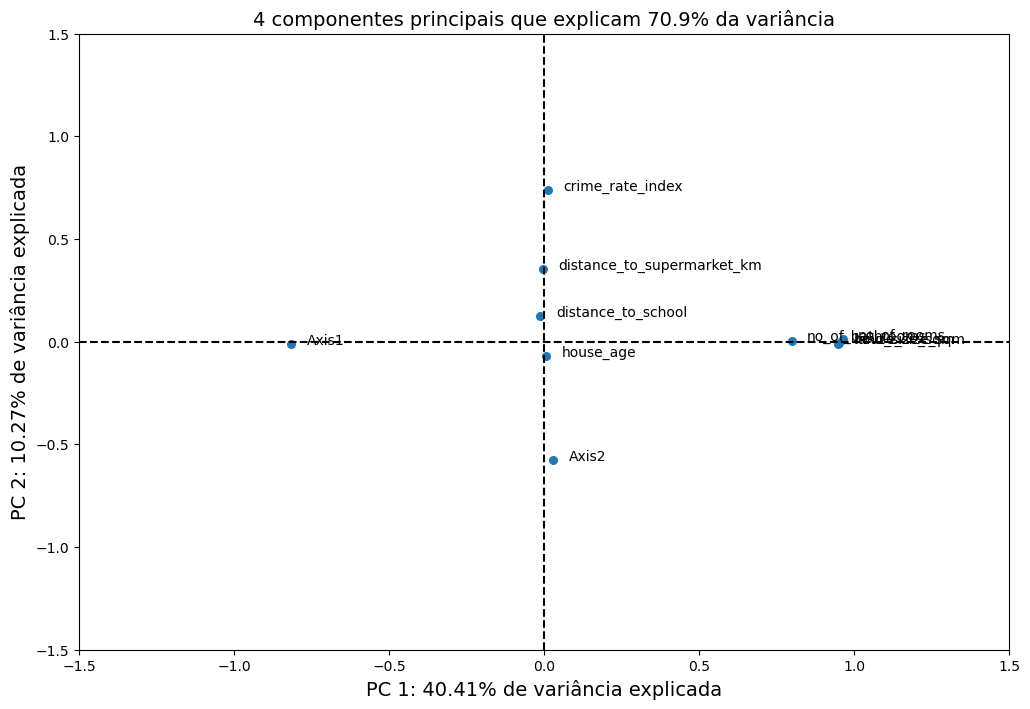

In [162]:
# Gráfico das cargas fatoriais e suas variâncias nos componentes principais
# Loading plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

tabela_cargas_chart = tabela_cargas.reset_index()

plt.scatter(tabela_cargas_chart['Fator_1'], tabela_cargas_chart['Fator_2'], s=30)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = tabela_cargas_chart['Fator_1'],
            y = tabela_cargas_chart['Fator_2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='black', ls='--')
plt.axvline(x=0, color='black', ls='--')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.title(f"{tabela_eigen.shape[0]} componentes principais que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=14)
plt.xlabel(f"PC 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=14)
plt.ylabel(f"PC 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=14)
plt.show()

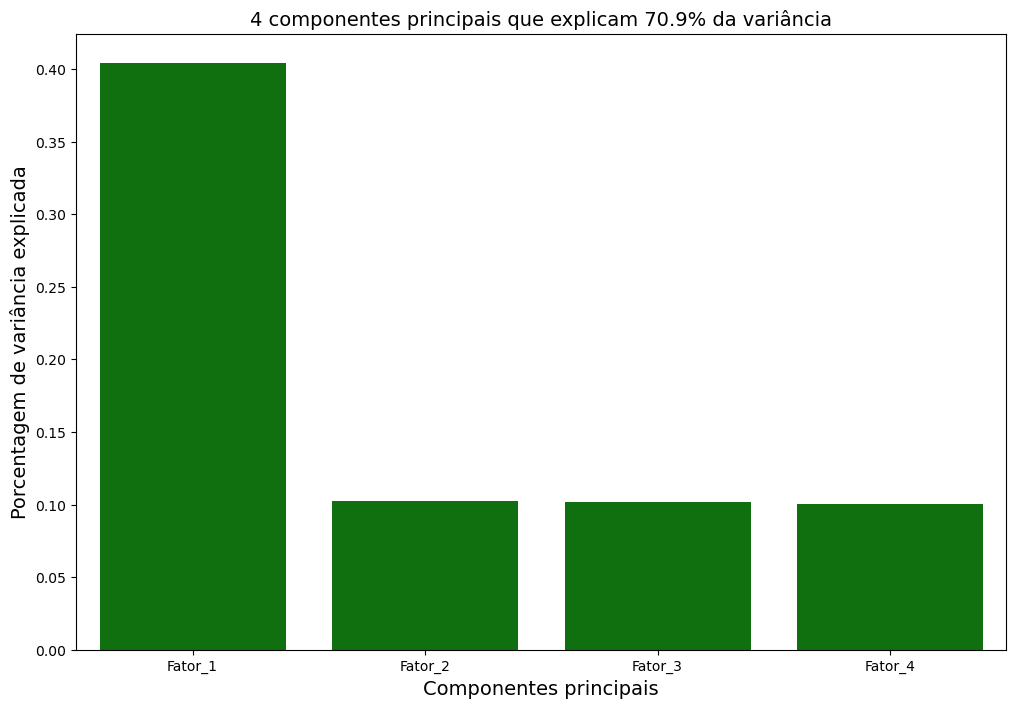

In [163]:
#%% Gráfico da variância acumulada dos componentes principais

plt.figure(figsize=(12,8))

plt.title(f"{tabela_eigen.shape[0]} componentes principais que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=14)
sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, color='green')
plt.xlabel("Componentes principais", fontsize=14)
plt.ylabel("Porcentagem de variância explicada", fontsize=14)
plt.show()

In [164]:
#%% Criando um ranking

df['Ranking'] = 0

for index, item in enumerate(list(tabela_eigen.index)):
    variancia = tabela_eigen.loc[item]['Variância']

    df['Ranking'] = df['Ranking'] + df[tabela_eigen.index[index]]*variancia


df = df.sort_values(by='Ranking', ascending=False)
df

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,...,water_front,distance_to_supermarket_km,crime_rate_index,room_size_class,property_value,Fator_1,Fator_2,Fator_3,Fator_4,Ranking
1272,773,760,8,9,Yes,Yes,Yes,Yes,3.5,Yes,...,No,6.5,4.08,Three,576789,4.095163,1.007368,1.080640,0.542303,1.922638
3274,783,737,8,6,Yes,Yes,Yes,Yes,0.7,Yes,...,Yes,6.4,5.91,Two,684338,3.711790,-0.564544,1.482054,2.726560,1.866962
1700,788,737,8,7,Yes,Yes,Yes,Yes,4.2,Yes,...,No,6.8,3.70,Two,609407,3.791845,0.725168,1.245105,1.063123,1.840219
121,707,706,8,8,Yes,Yes,Yes,Yes,4.6,Yes,...,Yes,4.2,5.98,Three,633937,3.731883,-0.311909,1.303314,1.991127,1.808828
2165,727,642,8,9,Yes,Yes,Yes,Yes,6.7,Yes,...,No,4.1,5.64,Three,549116,3.696189,1.458629,1.346072,-0.551868,1.724501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4890,101,101,1,1,No,No,No,No,1.1,No,...,No,0.2,2.70,Two,51999,-1.728345,-1.170086,-0.642637,-1.346304,-1.019427
2358,130,130,1,1,No,No,No,No,1.5,No,...,No,0.9,0.17,Zero,94429,-1.694051,-2.386525,-0.289774,-0.755376,-1.035200
4883,111,96,1,2,No,Yes,No,No,1.4,No,...,No,0.6,0.26,One,86040,-1.519672,-1.223582,-1.048400,-1.930576,-1.040612
4214,107,103,1,1,No,No,No,No,1.1,No,...,No,1.4,0.23,One,87009,-1.766703,-1.026252,-1.942285,-0.380589,-1.054775
